# ECE6530 DSP Group 3 Project
# Lab P-10: Bar Code Detection, Exercise 3.2
### Group Members: Grant Brown, Thomas Warren, Rick Lyon

In [1]:
# Load the required libraries
import matplotlib.pyplot as plt
import numpy as np
from barcode import stem_plot, upc_decode, decode_image

np.set_printoptions(suppress=True, precision=2)
plt.rc("xtick", direction="inout", labelsize="x-small")
plt.rc("ytick", direction="inout", labelsize="x-small")

%config InlineBackend.figure_formats = ['svg']

# 3.2 Bar Code Detection and Decoding
---- 
Develop the signal processing needed to decode a typical bar code from a scanned image.

## (a)
Read the image HP110v3.png and extract one row in the middle to define a 1-D signal x[n] for processing.

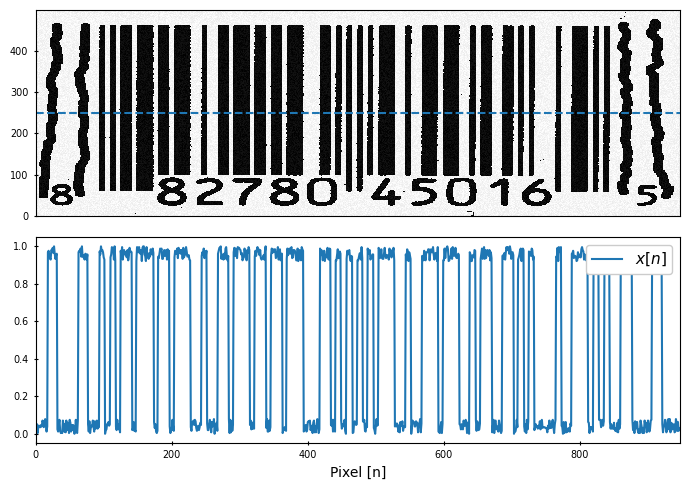

In [2]:
%config InlineBackend.figure_formats = ['png']
imagepath = "data/HP110v3.png"
im = 1 - plt.imread(imagepath)

# x and y vectors along image [pixels]
m, n = np.arange(len(im)), np.arange(len(im[0]))

# extract one row to read
read_row = int(len(m) / 2) - 1
xn = im[read_row]

fig, (im1, ax1) = plt.subplots(2, 1, figsize=(7, 5))
# plot the image, n is the columns which we want on the x-axis
n_mesh, m_mesh = np.meshgrid(n, np.flip(m))
im1.pcolormesh(n_mesh, m_mesh, im, cmap="binary")

# plot the location of the single row used for processing
im1.axhline(y=read_row, linestyle="dashed")
ax1.plot(np.arange(len(xn)), xn)
ax1.legend(["$x[n]$"], fontsize=11, loc="upper right", framealpha=1)

im1.grid(False)
ax1.set_xlabel("Pixel [n]")
im1.set_xticks([])
for ax in (im1, ax1):
    ax.set_xlim([n[0], n[-1]])

plt.tight_layout()

# (b)
Filter the signal $x[n]$ with a first difference FIR filter. 
$$
y[n] = x[n] - x[n-1]
$$

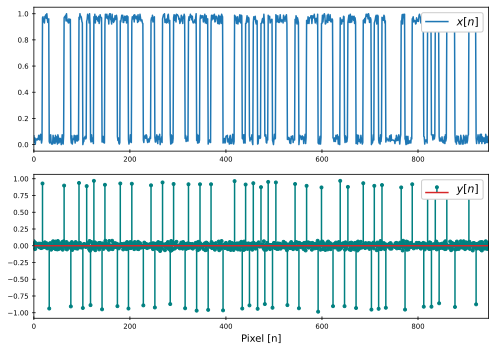

In [3]:
%config InlineBackend.figure_formats = ['svg']

# first difference filter of row signal
hn = np.array([1, -1])
yn = np.convolve(xn, hn)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(7, 5))
ax1.plot(np.arange(len(xn)), xn)
stem_plot(ax2, np.arange(len(yn)), yn, markersize=3)

ax1.legend(["$x[n]$"], fontsize=11, loc="upper right", framealpha=1)
ax2.legend(["$y[n]$"], fontsize=11, loc="upper right", framealpha=1)

ax2.set_xlabel("Pixel [n]")
for ax in (im1, ax1, ax2):
    ax.set_xlim([n[0], n[-1]])

plt.tight_layout()

# (c)
Create a sparse detected signal $d[n]$ by comparing the magnitude $|y[n]|$ to a threshold.

Use $\tau=0.5$ as the edge threshold.

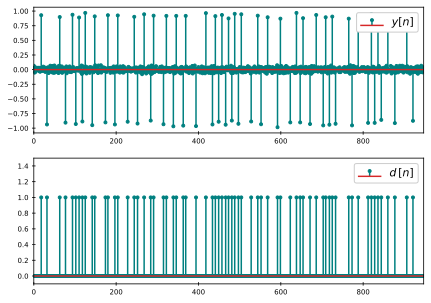

In [4]:
# apply edge threshold, difference must be 0.5 to be considered a valid edge
dn = np.where(np.abs(yn) > 0.5, 1, 0)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(7, 5))

stem_plot(ax1, np.arange(len(yn)), yn, markersize=3)
stem_plot(ax2, np.arange(len(dn)), dn, markersize=3)
ax2.set_ylim([-0.1, 1.5])

ax1.legend(["$y[n]$"], fontsize=11, loc="upper right", framealpha=1)
ax2.legend(["$d \, [n]$"], fontsize=11, loc="upper right", framealpha=1)

for ax in (im1, ax1, ax2):
    ax.set_xlim([n[0], n[-1]])

Then convert the sparse signal $d[n]$ into a location signal $\ell[n]$ by using the find function to extract locations.

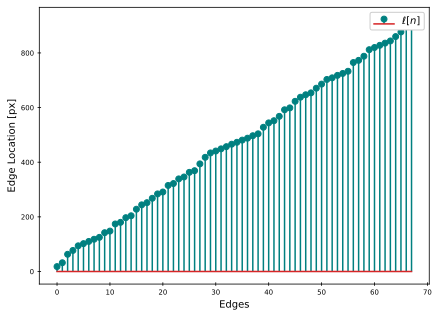

In [5]:
# pixel locations where edges occur
edge_loc = np.nonzero(dn)[0]

fig, (ax1) = plt.subplots(1, 1, figsize=(7, 5))
stem_plot(ax1, np.arange(len(edge_loc)), edge_loc)
ax1.set_ylabel("Edge Location [px]")
ax1.set_xlabel("Edges")
ax1.legend(["$\ell[n]$"], loc="upper right", framealpha=1)

## (d)
Apply a first difference filter to $\ell[n]$, call this signal $\Delta[n]$, which should be the width of each bar.

All of the bar widths of $\Delta[n]$ are grouped around four distinct values (8, 16, 24, 32px), which indicates there are 4 unique bar widths. 

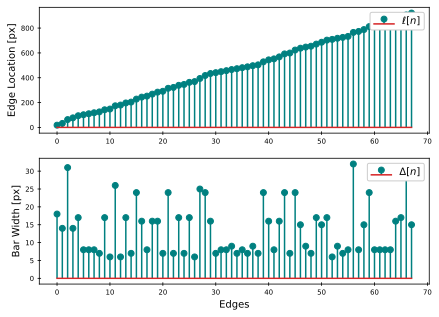

In [6]:
# difference filter on the location signal
delta_n = np.convolve(edge_loc, hn, mode="same")

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(7, 5))
stem_plot(ax1, np.arange(len(edge_loc)), edge_loc)
stem_plot(ax2, np.arange(len(delta_n)), delta_n)

ax1.set_ylabel("Edge Location [px]")
ax2.set_ylabel("Bar Width [px]")
ax2.set_xlabel("Edges")

ax1.legend(["$\ell[n]$"], loc="upper right", framealpha=1)
ax2.legend(["$\Delta[n]$"], loc="upper right", framealpha=1);

## (e)
Prove that the total width of a valid 12-digit bar code is equal to 95 $\theta_1$, where $\theta_1$ is the minimum bar width in pixels. Write a logical
argument to justify this total width.

Each encoded digit contains 7 units:   
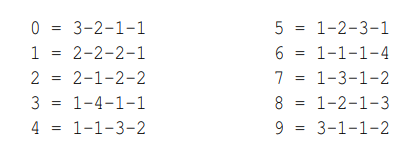

So the 12-digits take up a total width of 84 units, or 84 $\theta_1$. The 12 digits are delimited by three bars of width $\theta_1$ on either end, as well as separated between the 6th and 7th digit by 5 bars. The full length of the bar code is,

$$ 84 \theta_1 + 6\theta_1 + 5 \theta_1  = 95 \theta_1 $$

## (f)
Derive a simple method to estimate $\theta_1$ from the signal $\Delta[n]$.

For a valid barcode, the bar widths are multiples of the thinnest bar. This means that we can draw a line halfway between the bar widths with the smallest widths in $\Delta[n]$, and the next largest bars. Any bar below this line will be considered $\theta_1$, and any above are considered $2\theta_1$. To estimate $\theta_1$ for a noisy image, we average all the bar widths below this imaginary line, which we draw at 1.5x the minimum bar width found in the image.

This method gives $\theta_1 = 7.5$ for this image.

In [7]:
# determine minimum bar width in pixels
# take all widths smaller than 1.8x the minimum and take the average
min_width_group = delta_n[delta_n <= (np.min(delta_n) * 1.5)]
delta_1 = np.average(min_width_group)

print(f"delta_1 = {delta_1}")

delta_1 = 7.529411764705882


## (g)
Using the estimate for $\delta_1$, convert $\Delta[n]$ into relative sizes by dividing by $\theta_1$ and rounding. 

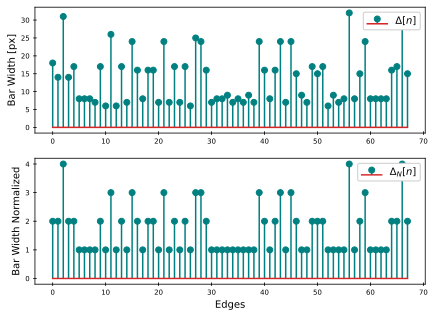

In [8]:
# normalize the bar widths by delta_1, and clip between 1 and 4.
delta_norm_n = np.clip(np.round(delta_n / delta_1), 1, 4)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(7, 5))
stem_plot(ax1, np.arange(len(delta_n)), delta_n)
stem_plot(ax2, np.arange(len(delta_n)), delta_norm_n)

ax1.set_ylabel("Bar Width [px]")
ax2.set_ylabel("Bar Width Normalized")
ax2.set_xlabel("Edges")
ax2.set_yticks([0, 1, 2, 3, 4])

ax1.legend(["$\Delta[n]$"], loc="upper right", framealpha=1)
ax2.legend(["$\Delta_N[n]$"], loc="upper right", framealpha=1)

## (h)
Decode the normalized $\Delta[n]$ signal into digits.

In [9]:
# find the first sequence of 3 ones, this marks the beginning and end of a valid code
delimiter_match = np.convolve(delta_norm_n, [1, 1, 1])
delimiter_loc = np.argwhere(delimiter_match == 3).flatten()
start_loc, stop_loc = delimiter_loc[0] - 2, delimiter_loc[-1]

# clip start location to 0
start_loc = 0 if start_loc < 0 else start_loc
# clip the sequence at the delimters
bar_w = delta_norm_n[start_loc : stop_loc + 1]

# a valid bar code should have 59 widths excluding the delimiters
assert len(bar_w) == 59

print(upc_decode(bar_w))

[8, 8, 2, 7, 8, 0, 4, 5, 0, 1, 6, 5]


# (i)

Check the result using the included code in the image.

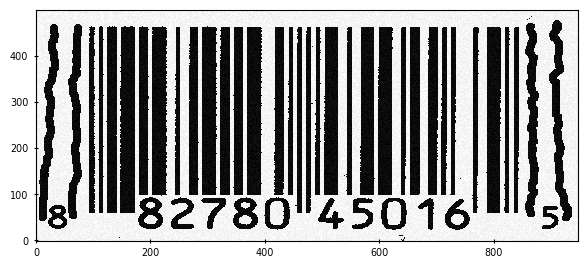

In [10]:
%config InlineBackend.figure_formats = ['png']

fig, (im1) = plt.subplots(1, 1, figsize=(7, 3))
# plot the image, n is the columns which we want on the x-axis
n_mesh, m_mesh = np.meshgrid(n, np.flip(m))
im1.pcolormesh(n_mesh, m_mesh, im, cmap="binary")
im1.grid(False)

# (j)

Process the image `Offv3.png`.

Because this image is slanted and the thinnest bar is only 2-3 pixels wide, it is helpful to average the $\Delta_n$ signals of several rows in the middle of the image.

[0, 4, 6, 5, 0, 0, 7, 0, 3, 1, 9, 5]

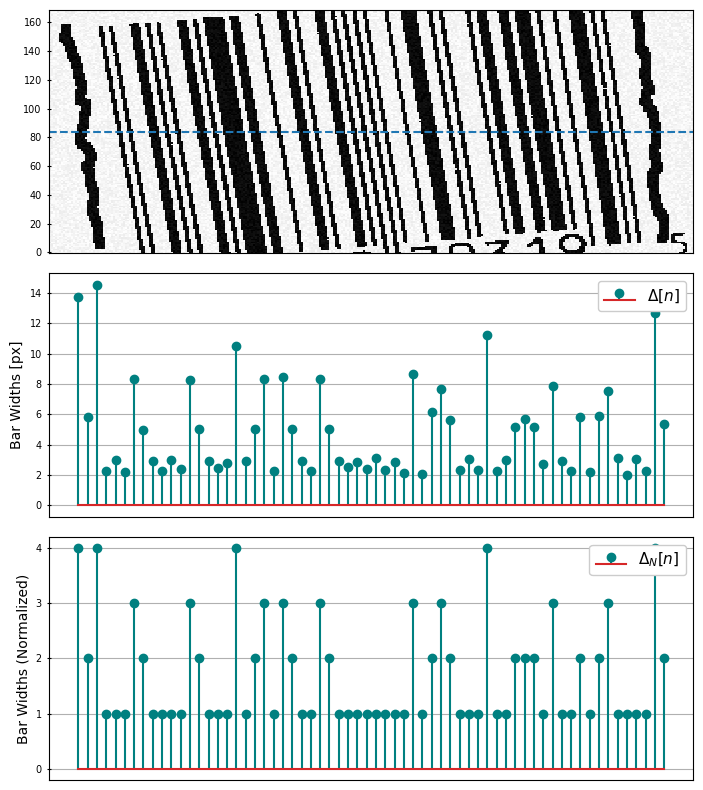

In [11]:
imagepath = "data/OFFv3.png"
decode_image(imagepath)

In [12]:
from IPython.display import display, HTML
from ipylab import JupyterFrontEnd
import subprocess

app = JupyterFrontEnd()

display(
    HTML(
        "<style>"
        ".jp-Cell { overflow-x: visible; overflow: visible; "
        "width: 95%; max-width: 960px; "
        "margin-left: auto; margin-right: auto; }"
        "img {"
        "width: 90%;"
        "height: 100%;}"
        ".jp-Cell-inputWrapper { width: 95%; overflow-x: visible; overflow: visible;}"
        "</style>"
    )
)

app.commands.execute("docmanager:save")
subprocess.run("jupyter nbconvert --to html main.ipynb", shell=True)
app.commands.execute("docmanager:save");